# Исследование интернет-магазина компьютерных игр

В рамках учебного проекта нам необходимо выявить закономерности, определяющие успешность игр для интернет-магазина компьютерных игр «Стримчик». У нас есть доступ к историческим данным из открытых источников, включающих информацию о продажах игр, оценках пользователей и экспертов, а также жанрах и платформах (например, таких как Xbox и PlayStation). Данные охватывают период до 2016 года. Результаты  исследования позволят нам спланировать кампанию на 2017-й год.

**Описание данных:**

* Name — название игры

* Platform — платформа

* Year_of_Release — год выпуска

* Genre — жанр игры

* NA_sales — продажи в Северной Америке (миллионы проданных копий)

* EU_sales — продажи в Европе (миллионы проданных копий)

* JP_sales — продажи в Японии (миллионы проданных копий)

* Other_sales — продажи в других странах (миллионы проданных копий)

* Critic_Score — оценка критиков (максимум 100)

* User_Score — оценка пользователей (максимум 10)

* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
from scipy.stats import pearsonr

## Обзор данных

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Вывод:**


В DataFrame имеются пропуски, а также в некоторых столбцах установлены некорректные типы данных.

## Подготовка данных

### Предобработка данных

Приведём названия столбцов к нижнему регистру.

In [6]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Удалим пропуски в столбце «name», а заодно и в столбце «genre». Пропуски в них совпадают.

In [7]:
data = data.dropna(subset=['name']).reset_index(drop=True)

Проверим колличество пропусков в столбце «year_of_release».

In [8]:
data['year_of_release'].isna().sum()

269

Скорее всего, эти игры еще не были изданы на момент сбора данных. Поэтому удалим строки с пропусками.

In [9]:
data = data.dropna(subset=['year_of_release']).reset_index(drop=True)

изменим для удобства в столбце «year_of_release» тип данных с «float64» на «int64».

In [10]:
data['year_of_release'] = data['year_of_release'].astype('int')

Проверим пропуски в столбце «critic_score»

In [11]:
data['critic_score'].isna().sum()

8461

Около половины всех строк в DataFrame содержат пропуски в этом столбце. К сожалению, мы не можем удалить эти строки, так как это приведет к значительному сокращению объема данных. Также не представляется возможным заполнить пропуски, потому что наши оценки будут далёкими от реальных. Это справедливо и для столбца «user_score».

Проверим почему у столбца «user_score» тип данных «object», а не «float64».

In [12]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

«tbd» в контексте столбца «user_score» означает, что рейтинг пользователей не определен, то есть игра  не получила оценку. Заменим «tbd» на «NaN», а затем поменяем тип данных на «float64».

In [13]:
data['user_score'] = data['user_score'].replace('tbd', np.nan)

In [14]:
data['user_score'] = data['user_score'].astype('float')

Система ESRB применяется только в США, Канаде и Мексике, поэтому мы не будем пока заполнять пропуски в столбце «rating».

In [15]:
data.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

1

In [16]:
data = data.drop_duplicates(subset=['name', 'platform', 'year_of_release']).reset_index(drop=True)

Избавились от явных дубликатов.

In [17]:
data.groupby(['name', 'platform', 'year_of_release']).size().reset_index(name='count').query('count > 1').count()

name               0
platform           0
year_of_release    0
count              0
dtype: int64

In [18]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [19]:
data['year_of_release'].unique()

array([2006, 1985, 2008, 2009, 1996, 1989, 1984, 2005, 1999, 2007, 2010,
       2013, 2004, 1990, 1988, 2002, 2001, 2011, 1998, 2015, 2012, 2014,
       1992, 1997, 1993, 1994, 1982, 2016, 2003, 1986, 2000, 1995, 1991,
       1981, 1987, 1980, 1983])

### Промежуточные вычисления

In [20]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [21]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

В ходе предобрабоки данных мы привели названия столбцов к нижнему регистру.  Также были обнаружены пропуски в столбцах year_of_release, name, genre, critic_score, user_score и rating. Мы удалили строки с пропусками в столбцах year_of_release, name и genre, а в остальных столбцах было решено на данном этапе оставить пропуски.
Мы изменили типы данных в столбцах user_score и year_of_release. Кроме того, заменили значение tbd в user_score на NaN. Также проверили данные на дубликаты и избавились от них. Помимо всего прочего нами был добавлен столбец с общими продажами по регионам.

## Исследовательский анализ данных

### Объем выпуска игр в разные годы

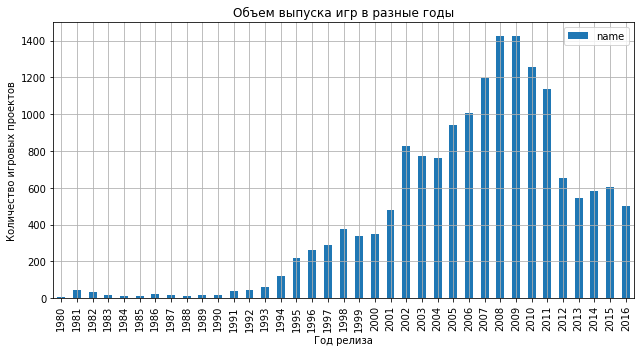

In [23]:
data.pivot_table(
    index='year_of_release', 
    values='name', 
    aggfunc='count'
).plot(
    kind='bar', 
    grid=True, 
    figsize=(9, 5)
)

plt.ylabel('Количество игровых проектов')
plt.xlabel('Год релиза')
plt.title('Объем выпуска игр в разные годы')
plt.tight_layout()
plt.show()

**Вывод:**

Согласно имеющимся данным, до 1995 года количество выпущенных игр составляло менее 200 проектов в год. После этого наблюдается постепенное увеличение числа проектов. С 2002 года разработка игр начинает резко расти, и эта тенденция сохраняется до 2011 года, после чего следует резкое снижение количества новых проектов. Данных об играх до 1995 года слишком мало, чтобы на их основании делать какие-либо выводы. Полагаю, они не имеют большого значения для исследования.

### Продажи по платформам

Для начала оценим продажи по всем имеющимся игровым платформам.

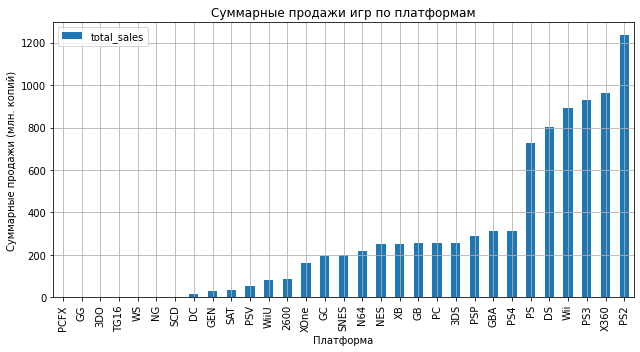

In [24]:
sales_by_platform = data.pivot_table(
    index='platform', 
    values='total_sales', 
    aggfunc='sum'
).sort_values(
    by='total_sales',
)

sales_by_platform.plot(
    kind='bar', 
    grid=True, 
    figsize=(9, 5)
)

plt.ylabel('Суммарные продажи (млн. копий)')
plt.xlabel('Платформа')
plt.title('Суммарные продажи игр по платформам')
plt.tight_layout()
plt.show()

У нас есть безусловный топ-6 по общим продажам. Давайте посмотрим, как ситуация в этом топе менялась в зависимости от года.

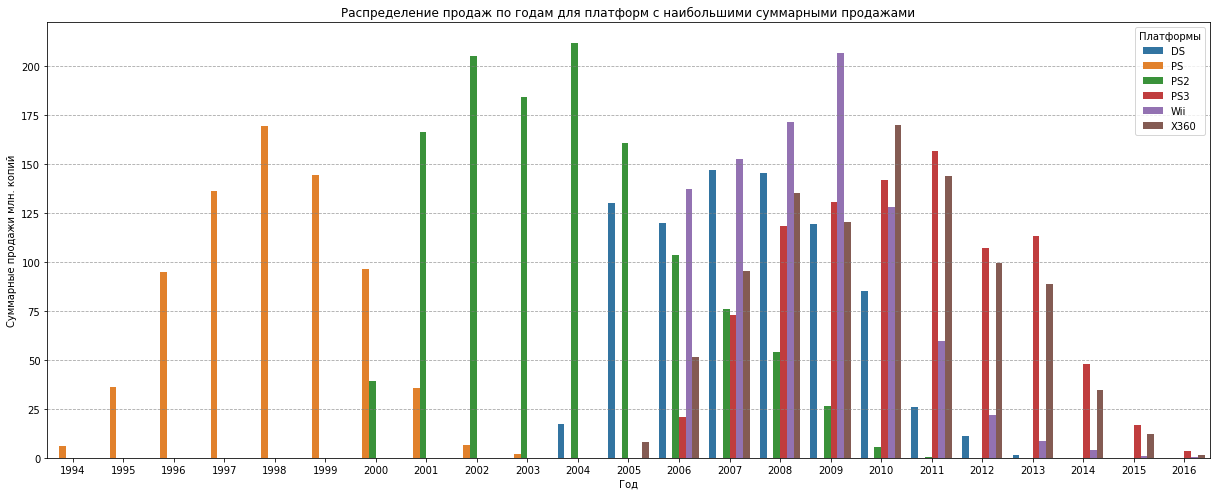

In [25]:
top_platforms = sales_by_platform.reset_index().nlargest(6, 'total_sales')['platform']

df_platforms = (
    data[data['platform'].isin(top_platforms)]
    .query('year_of_release >= 1994')
    .pivot_table(
        index=['platform', 'year_of_release'], 
        values='total_sales', 
        aggfunc='sum'
    )
    .reset_index()
)
  


plt.figure(figsize=(17, 7))
sns.barplot(data=df_platforms, x='year_of_release', y='total_sales', hue='platform')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.title('Распределение продаж по годам для платформ с наибольшими суммарными продажами')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи млн. копий')
plt.legend(title='Платформы')
plt.tight_layout()
plt.show()

**Годы выпуска платформ:**

1. Nintendo DS: 2004
2. PlayStation (PS1): 1994
3. PlayStation 2 (PS2): 2000
4. PlayStation 3 (PS3): 2006
5. Nintendo Wii: 2006
6. Xbox 360 (X360): 2005

**Вывод:** 

Игровые платформы от Sony, принадлежащие к серии PlayStation, пользуются наибольшей популярностью и демонстрируют самые высокие показатели продаж копий игр. Безусловным историческим лидером по популярности является PlayStation 2. Также стоит отметить консоли от Nintendo и Microsoft, игры для которых также пользуются большим спросом. Sony выпускает новые поколения консолей PlayStation примерно каждые 6–7 лет. В первый год после выхода новой игровой платформы она значительно уступает предыдущему поколению по продажам игр. Это объясняется отчасти меньшим количеством доступных игр по сравнению с предшественником. В среднем жизненный цикл приставки составляет около 7 лет. После этого продажи игр для неё сильно становятся минимальными. Microsoft, как один из основных конкурентов Sony, выпускает новые консоли примерно с такой же периодичностью. Nintendo DS — это портативная игровая система, а Nintendo Wii — полноценная консоль. Этим объясняется небольшой промежуток времени между выпуском этих платформ. Также хочу отметить, что Wii была самой успешной платформой Nintendo, и на старте продаж игры для неё расходились большим количеством копий, чем для других представленных здесь конкурентов.

### Актуальный период для прогноза на 2017-й

В 2013 году Sony и Microsoft выпустили новые поколения своих консолей, поэтому предлагаю рассмотреть актуальный период с 2013 по 2016 год. В это же время увеличилось количество инди-игр, а также активно начали развиваться онлайн-сервисы, такие как PlayStation Plus и Xbox Live Gold.

In [27]:
actual_data = data.query('year_of_release >= 2013').reset_index(drop=True)

### Топ платформ по продажам

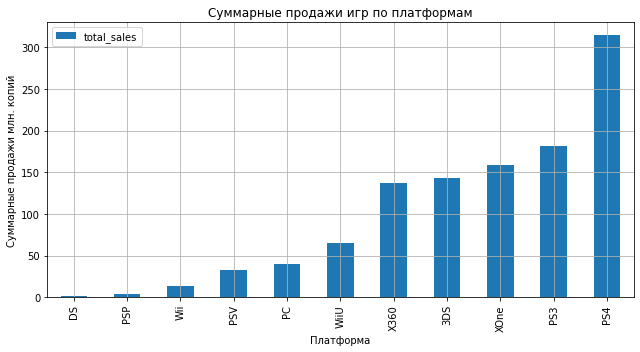

In [28]:
actual_top_platform = actual_data.pivot_table(
    index='platform', 
    values='total_sales', 
    aggfunc='sum'
)

actual_top_platform.sort_values(
    by='total_sales'
).plot(
    kind='bar', 
    figsize=(9, 5),
    grid=True
)

plt.ylabel('Суммарные продажи млн. копий')
plt.title('Суммарные продажи игр по платформам')
plt.xlabel('Платформа')
plt.tight_layout()
plt.show()

**Вывод:** 

Спрос на игры для Xbox 360 и PlayStation 3 начал снижаться, в то время как Xbox One и PlayStation 4 набирают популярность. Особенно стоит обратить внимание на PlayStation 4. Игры для этой платформы расходятся наибольшим количеством копий по сравнению с конкурентами. Интерес к Wii значительно упал, и в последнее время более популярной стала портативная игровая система Nintendo 3DS, которая вышла на 5 лет позже, чем Wii.

### Продажи игр в разбивке по платформам

In [29]:
df_actual_platform = actual_top_platform.reset_index()['platform']

top5_platform = actual_data[actual_data['platform'].isin(df_actual_platform)].reset_index(drop=True)

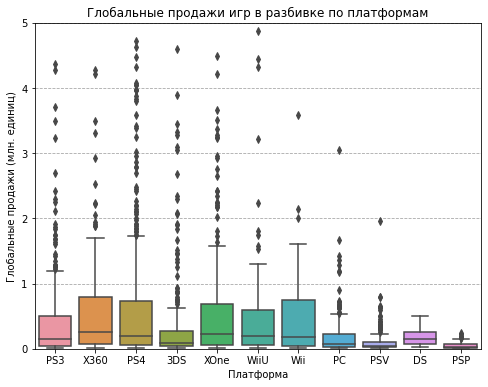

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='platform', y='total_sales', data=top5_platform)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн. единиц)')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.gca().set_ylim(0, 5)
plt.show()


In [31]:
top5_platform['total_sales'].describe()

count    2233.000000
mean        0.488442
std         1.235226
min         0.010000
25%         0.030000
50%         0.110000
75%         0.400000
max        21.050000
Name: total_sales, dtype: float64

In [32]:
top5_platform.nlargest(10, 'total_sales').sort_values(by='total_sales', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
6,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
7,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
8,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN,9.18
9,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58


**Вывод:**

Самой продаваемой игрой для PlayStation 3 и Xbox 360 в период с 2013 по 2016 год стала Grand Theft Auto V. Она вышла эксклюзивно на этих консолях в 2013 году и только в 2015-м стала доступна на других платформах. Два самых больших выброса в наших данных приходятся именно на эту игру. Игровые бестселлеры и популярные эксклюзивы расходятся гигантскими тиражами по сравнению с основной массой проектов. 

### Влияние отзывов на продажи

Давайте создадим новый DataFrame, включающий данные за актуальный период и не имеющий пропусков в столбце «critic_score», а также отфильтрованный по платформе PS4.

In [33]:
df_critic_score = top5_platform.dropna(subset=['critic_score']).reset_index(drop=True)
ps4_critic_score= df_critic_score.query('platform == "PS4"')

Повторим те же действия для «user_score». 

In [34]:
df_user_score = top5_platform.dropna(subset=['user_score']).reset_index(drop=True)
ps4_user_score = df_user_score.query('platform == "PS4"')

Посмотрим как влияют отзывы критиков на продажи.

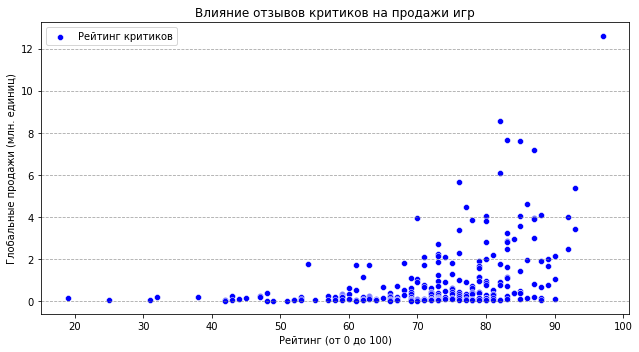

Корреляция между отзывами критиков и продажами: 0.41


In [35]:
plt.figure(figsize=(9, 5))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_critic_score, color='blue', label='Рейтинг критиков')

plt.title('Влияние отзывов критиков на продажи игр')
plt.xlabel('Рейтинг (от 0 до 100)')
plt.ylabel('Глобальные продажи (млн. единиц)')
plt.legend()
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

critic_correlation, _ = pearsonr(ps4_critic_score['critic_score'], ps4_critic_score['total_sales'])

print(f'Корреляция между отзывами критиков и продажами: {critic_correlation:.2f}')

 * 1: Полная положительная линейная зависимость.
 * -1: Полная отрицательная линейная зависимость.
 * 0: Нет линейной зависимости.

Теперь рассмотрим, как отзывы пользователей влияют на продажи.

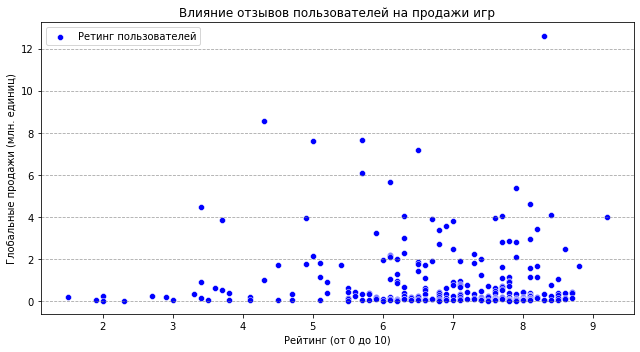

Корреляция между отзывами пользователей и продажами: -0.03


In [36]:
plt.figure(figsize=(9, 5))
sns.scatterplot(x='user_score', y='total_sales', data=ps4_user_score, color='blue', label='Ретинг пользователей')

plt.title('Влияние отзывов пользователей на продажи игр')
plt.xlabel('Рейтинг (от 0 до 10)')
plt.ylabel('Глобальные продажи (млн. единиц)')
plt.legend()
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

user_correlation, _ = pearsonr(ps4_user_score['user_score'], ps4_user_score['total_sales'])

print(f'Корреляция между отзывами пользователей и продажами: {user_correlation:.2f}')

**Вывод:**

Между отзывами критиков и продажами игр наблюдается умеренная положительная корреляция, в то время как для отзывов пользователей характерна слабая отрицательная корреляция. Это указывает на то, что критики, вероятно, оценивают игры более объективно по сравнению с пользователями. Эта тенденция подтверждается визуальным анализом на диаграмме рассеяния.

Теперь проверим, насколько справедлив наш вывод относительно других игровых платформ.

In [39]:
xone_score = actual_data.query('platform == "XOne"')
ps3_score = actual_data.query('platform == "PS3"')
x360_score = actual_data.query('platform == "X360"')


columns_to_compare = ['user_score', 'critic_score']

def get_scatterplot(df):
    for column in columns_to_compare:
        plt.figure(figsize=(9, 5))
        sns.scatterplot(x=df[column], y=df['total_sales'], color='blue', label='Ретинг')
        plt.title(f'Влияние отзывов {column} на продажи игр')
        plt.xlabel('Рейтинг')
        plt.ylabel('Глобальные продажи (млн. единиц)')
        plt.legend()
        plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
        plt.tight_layout()
        plt.show()   
        
#get_scatterplot(xone_score)  


def get_correlation(df_cor):
    for column in columns_to_compare:
        sub_df = df_cor.dropna(subset=[column])
        correlation, _ = pearsonr(sub_df[column], sub_df['total_sales'])
        print(f'Корреляция между отзывами {column} и продажами: {correlation:.2f}')
        
        
    
#get_correlation(xone_score)

Рассмотрим ситуацию для Xbox One.

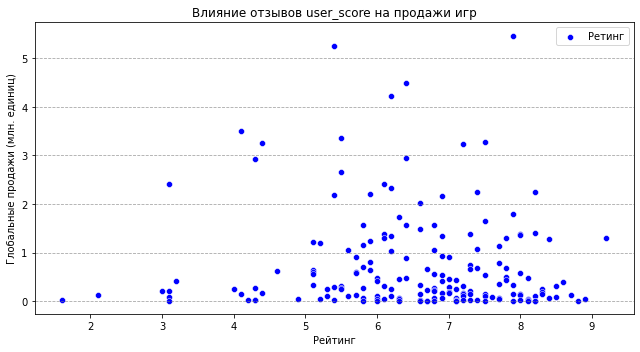

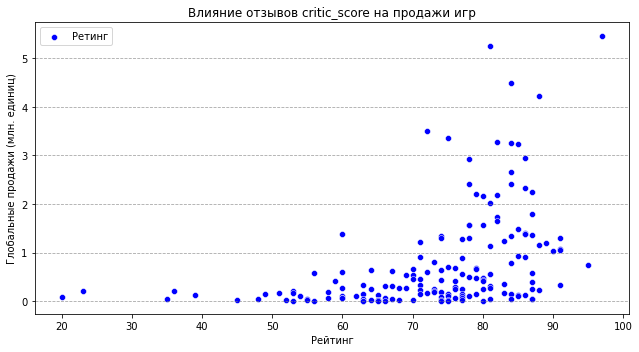

In [40]:
get_scatterplot(xone_score)

In [41]:
get_correlation(xone_score)

Корреляция между отзывами user_score и продажами: -0.07
Корреляция между отзывами critic_score и продажами: 0.42


Теперь посмотрим, как обстоят дела у PlayStation 3.

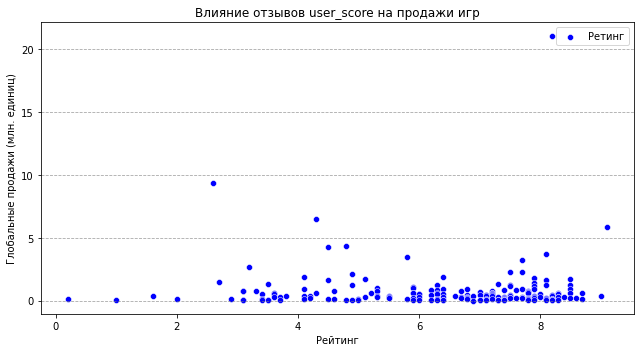

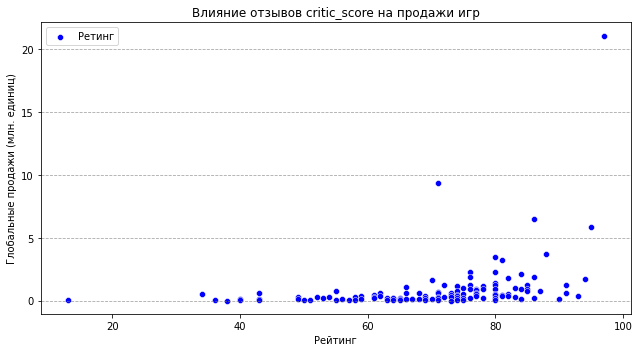

In [42]:
get_scatterplot(ps3_score)

In [43]:
get_correlation(ps3_score)

Корреляция между отзывами user_score и продажами: 0.00
Корреляция между отзывами critic_score и продажами: 0.33


Чтобы быть уверенными в полноте картины, давайте также рассмотрим ситуацию с Xbox 360.

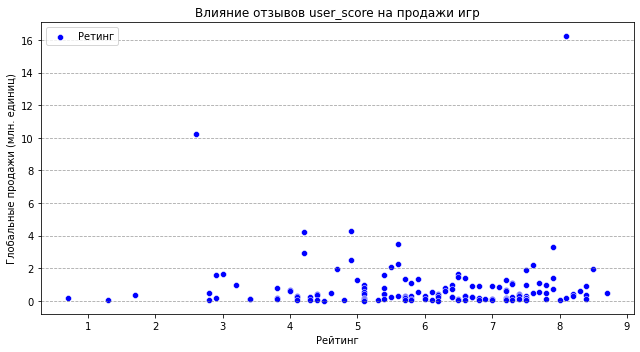

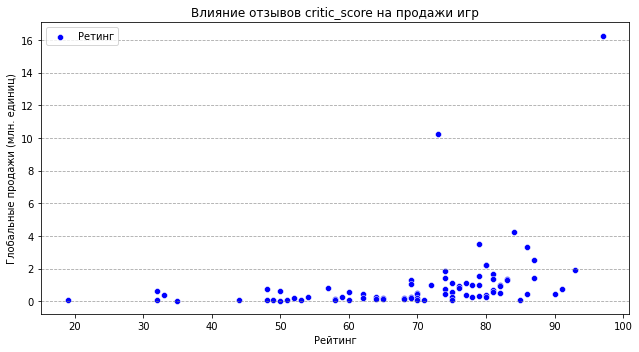

In [44]:
get_scatterplot(x360_score)

In [45]:
get_correlation(x360_score)

Корреляция между отзывами user_score и продажами: -0.01
Корреляция между отзывами critic_score и продажами: 0.35


In [46]:
top5_platform.query('name == "Call of Duty: Ghosts"').nlargest(2, 'total_sales')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
6,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
7,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36


Наши наблюдения также применимы и к другим платформам. Например, Call of Duty: Ghosts для Xbox 360 разошлась тиражом 10.24 млн копий, а для PlayStation 3 — 9.36 млн копий. Однако признание пользователей игра не получила: её оценка составляет лишь 2.6. В то же время критики оценили её в 71.0 для PS3 и 73.0 для Xbox 360.

### Общее распределение игр по жанрам

Взглянем на общую картину.

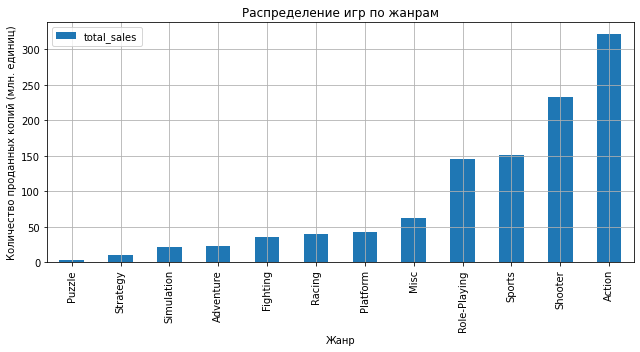

In [48]:
#top5_platform.pivot_table(
actual_data.pivot_table(
    index='genre',  
    values='total_sales', 
    aggfunc='sum'
).sort_values(by='total_sales').plot(kind='bar', figsize=(9, 5), grid=True)

plt.ylabel('Количество проданных копий (млн. единиц)')
plt.xlabel('Жанр')
plt.title('Распределение игр по жанрам')
plt.tight_layout()
plt.show()

Теперь рассмотрим, на каких платформах игры каких жанров имеют самые высокие тиражи.

In [49]:
#pivot_table = top5_platform.pivot_table(
pivot_table = actual_data.pivot_table(
    index='genre', 
    #columns='platform',  
    values='total_sales', 
    #aggfunc='sum'
    aggfunc='median'
)

#pivot_table['total'] = pivot_table.sum(axis=1)

pivot_table.sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


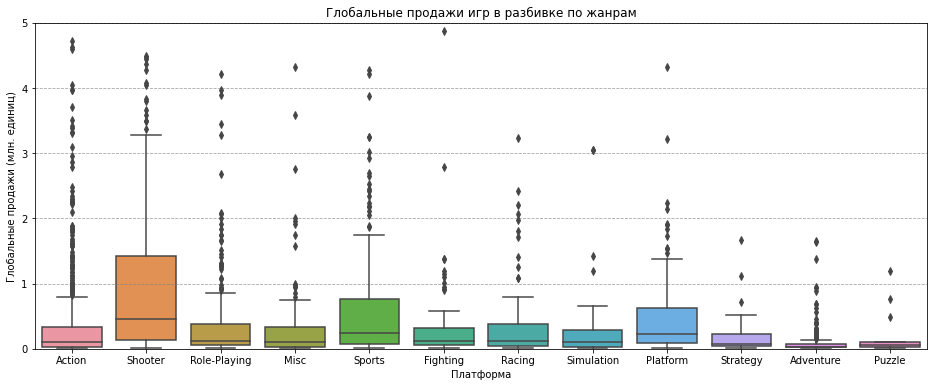

In [50]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='genre', y='total_sales', data=actual_data)
plt.title('Глобальные продажи игр в разбивке по жанрам')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи (млн. единиц)')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.gca().set_ylim(0, 5)
plt.show()

Вывод:

* Самым стабильным спросом пользуются шутеры. За ними идут спортивные игры и платформеры. Также у этих жанров присутствуют выбросы в виде игровых бестселлеров.

* Ролевые игры и файтинги тоже продаются хорошо. У ролевых игр есть значительные выбросы, которые указывают на то, что некоторые проекты становятся особенно популярными среди покупателей.

* В жанре экшен наблюдается много значительных выбросов — это говорит о том, что некоторые игры этого жанра становятся очень популярными.

### Вывод

* Пик производства новых игровых проектов пришёлся на период с 2007 по 2011 год, после чего разработка новых проектов сократилась почти вдвое.

* Самыми популярными игровыми консолями за всю историю являются:
    
    1. PlayStation 2;
    
    2. Xbox 360;
    
    3. PlayStation 3;
    
    4. Nintendo Wii;
    
    5. Nintendo DS;
    
    6. PlayStation.
    
* Средний срок жизни игровой платформы составляет около 7 лет.

* Актуальный период для прогнозов на 2017 год — это 2013–2016 годы, поскольку за этот промежуток произошли изменения в индустрии, которые стоит брать в расчёт для актуального прогноза.

* За выбранный нами актуальный период самыми популярными консолями являются:
   
    1. PS4;
    
    2. PS3;
    
    3. Xone;
    
    4. 3DS;
    
    5. Xbox 360.
    
* Единичные проекты, пользующиеся большой популярностью, создают основную массу продаж, в то время как большинство проектов расходится относительно небольшим тиражом.

* Игровые критики более точно оценивают игру, чем пользователи. Так, игры, получившие низкие или средние оценки у пользователей, могут расходиться большим тиражом.

* Жанры игр, которые пользуются самым стабильным спросом:

    1. Shooter
    2. Sports
    3. Platform
    4. Role-Playing
    5. Fighting

Также не стоит забывать о играх жанров action среди которых часто бывают хиты, которые расходятся гигантскими тиражами. Игры жанра racing показывают неплохой результат и тоже заслуживают внимания.

## Портрет пользователя каждого региона

### Топ-5 платформ для пользователей регионов (NA, EU, JP)

In [51]:
def get_top_platforms(region):
    top_platforms = actual_data.groupby('platform')[region].sum().nlargest(5)
    total_sales = actual_data[region].sum()
    other_sales = actual_data.groupby('platform')[region].sum().sum() - top_platforms.sum() #добавил доли других платформ
    top_platforms['other'] = other_sales 
    top_platforms_percentage = (top_platforms / total_sales)
    return top_platforms_percentage


na_top = get_top_platforms('na_sales')
eu_top = get_top_platforms('eu_sales')
jp_top = get_top_platforms('jp_sales')

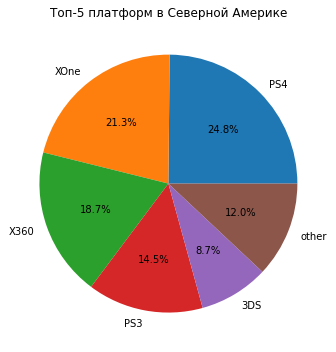

In [52]:
na_top.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('')
plt.title('Топ-5 платформ в Северной Америке')
plt.tight_layout()
plt.show()

**Вывод:**

На PlayStation 4 приходится 25 % продаж игр в Северной Америке, а на PlayStation 3 — чуть более 14 %. Доля Xbox One составляет примерно 21 %, а Xbox 360 — около 19 %. Это говорит о том, что популярность консолей Sony и Microsoft находится примерно на одном уровне. 3DS занимает около 9 % рынка продаж игр.

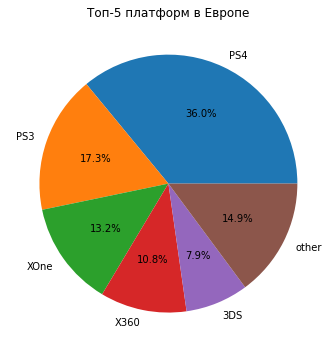

In [53]:
eu_top.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('')
plt.title('Топ-5 платформ в Европе')
plt.tight_layout()
plt.show()

**Вывод** 

На Европейском рынке консоли от Sony пользуются заметным преимуществом. Доля игр для PlayStation 4 составляет около 36 % от всех продаж, а для PlayStation 3 — примерно 17 %. Консоли от Microsoft занимают примерно равное положение: доля Xbox One составляет примерно 13 %, а Xbox 360 — около 11 %. Игры для 3DS занимают около 8 % от всех продаж.

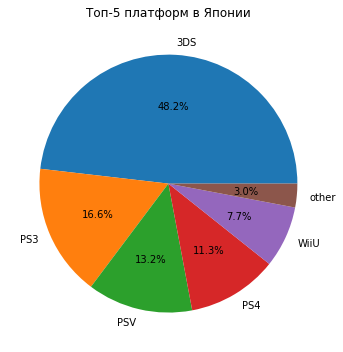

In [54]:
jp_top.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('') 
plt.title('Топ-5 платформ в Японии')
plt.tight_layout()
plt.show()

**Вывод:**

На Японском рынке ситуация отличается от других. Продажи игр для 3DS составляют примерно 48% от всех продаж. Для WiiU этот показатель составляет около 8%. Продажи игр для PS3 составляют примерно 17%, для PlayStation Vita — около 13%, а для PS4 — примерно 11%.

### Топ-5 жанров для пользователей регионов (NA, EU, JP)

In [55]:
#def get_top_genres(region):
    #top_genres = actual_data.groupby('genre')[region].sum().nlargest(5)
    #return top_genres

def get_top_genres(region):
    top_genres = actual_data.groupby('genre')[region].sum().nlargest(5)
    total_sales = actual_data[region].sum()
    other_sales = actual_data.groupby('genre')[region].sum().sum() - top_genres.sum() #добавил доли других платформ
    top_genres['other'] = other_sales 
    top_genres_percentage = (top_genres / total_sales)
    return top_genres_percentage

na_top_genre = get_top_genres('na_sales')
eu_top_genre = get_top_genres('eu_sales')
jp_top_genre = get_top_genres('jp_sales')

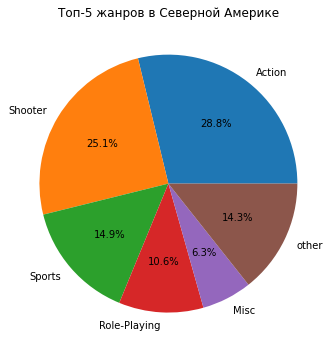

In [56]:
#na_top_genre.plot(kind='line', figsize=(7, 5), grid=True, style='o-')

#plt.ylabel('Продажи (млн. единиц)')
#plt.xlabel('Жанр')
#plt.title('Топ-5 жанров в Северной Америке')
#plt.tight_layout()
#plt.show()

na_top_genre.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('')
plt.title('Топ-5 жанров в Северной Америке')
plt.tight_layout()
plt.show()

**Вывод:** 

В Северной Америке на игры жанра action приходится около 29% продаж, а на shooter примерно 25%. Это, безусловно, два самых популярных жанра в регионе. Далее следуют спортивные игры с тиражом около 15%, ролевые игры с продажами около 11% и замыкает жанр misc с продажами около 6%. На жанры, которые не вошли в топ приходится около 14% продаж.

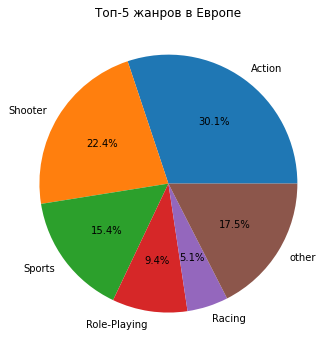

In [57]:
#eu_top_genre.plot(kind='line', figsize=(7, 5), grid=True, style='o-')

#plt.ylabel('Продажи (млн. единиц)')
#plt.xlabel('Жанр')
#plt.title('Топ-5 жанров в Европе')
#plt.tight_layout()
#plt.show()

eu_top_genre.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('')
plt.title('Топ-5 жанров в Европе')
plt.tight_layout()
plt.show()

**Вывод:** 

В Европейском регионе ситуация похожа на Северную Америку: на продажи игр жанра action приходится около 30%, sports около 15% и role-playing около 9%. Продажи игр жанра shooter немного меньше — около 22%. На последнем месте в топе находятся игры жанра racing. На жанры, которые не вошли в топ приходится около 17% продаж.

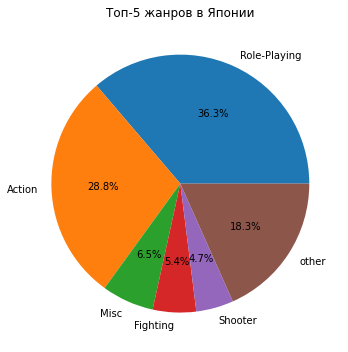

In [58]:
#jp_top_genre.plot(kind='line', figsize=(7, 5), grid=True, style='o-')

#plt.ylabel('Продажи (млн. единиц)')
#plt.xlabel('Жанр')
#plt.title('Топ-5 жанров в Японии')
#plt.tight_layout()
#plt.show()

jp_top_genre.plot(kind='pie', autopct='%1.1f%%', figsize=(7, 5), normalize=False)

plt.ylabel('')
plt.title('Топ-5 жанров в Японии')
plt.tight_layout()
plt.show()

**Вывод:**

В Японии продажи игр ниже, чем в других регионах. Также здесь отличается топ жанров. Первое место занимают ролевые игры с продажами около 36%. Затем идут экшены с продажами около 29%. Третье место занимает жанр misc с продажами 6.5%. Четвёртое место у файтингов с продажами около 5.4%. Замыкают топ шутеры с продажами около 4.7% миллиона копий. На другие жанры приходится около 18% всех продаж.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Удалим пропуски в столбце «rating» и создадим новый DataFrame df_esrb.

In [59]:
df_esrb = actual_data.dropna(subset=['rating']).reset_index(drop=True)

***ESRB принимают и определяют рейтинги для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде!***

**Расшифровка рейтингов**

* «E» («Everyone») — «Для всех»: Содержание вполне подходит для всех возрастов (ранее с 6 лет). Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера.

* «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет. Проекты с данным рейтингом могут содержать жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику.

* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови.

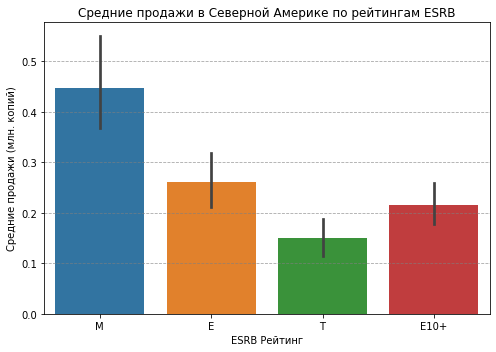

In [60]:
plt.figure(figsize=(7, 5))
sns.barplot(x='rating', y='na_sales', data=df_esrb)
plt.title('Средние продажи в Северной Америке по рейтингам ESRB')
plt.xlabel('ESRB Рейтинг')
plt.ylabel('Средние продажи (млн. копий)')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод:**
    
В Северной Америке в среднем лучше всего продаются игры «для взрослых». Чуть менее популярны игры «для всех» и игры «для всех от 10 лет и старше». Игры с рейтингом «подросткам» имеют меньшее количество продаж.

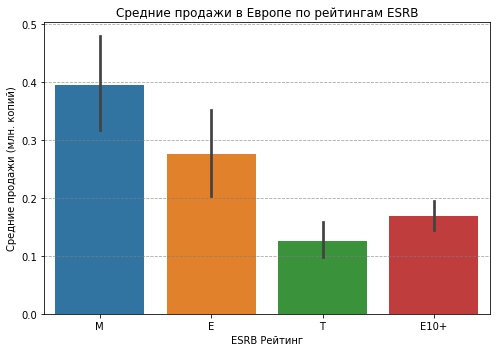

In [61]:
plt.figure(figsize=(7, 5))
sns.barplot(x='rating', y='eu_sales', data=df_esrb)
plt.title('Средние продажи в Европе по рейтингам ESRB')
plt.xlabel('ESRB Рейтинг')
plt.ylabel('Средние продажи (млн. копий)')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод:**
    
В европейском регионе ситуация схожая с Северной Америкой.     

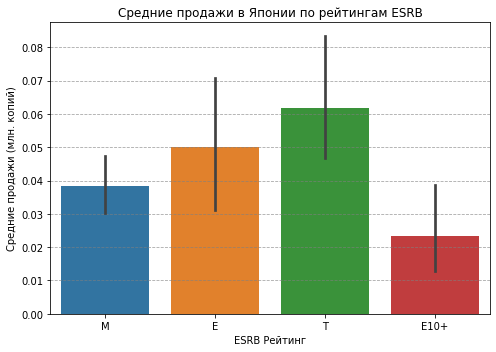

In [62]:
plt.figure(figsize=(7, 5))
sns.barplot(x='rating', y='jp_sales', data=df_esrb)
plt.title('Средние продажи в Японии по рейтингам ESRB')
plt.xlabel('ESRB Рейтинг')
plt.ylabel('Средние продажи (млн. копий)')
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

**Вывод:**

Японский регион: слишком мало данных, чтобы делать выводы.

## Проверка гипотез

### Гипотеза 1: Средние пользовательские рейтинги платформ Xbox One и PC равны

Нулевая гипотеза всегда говорит о равенстве или неизменности. Так как средние пользовательские рейтинги могут отклоняться в любую сторону, мы будем использовать двустороннюю альтернативную гипотезу.

* Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC равны.

* Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [64]:
alpha = 0.05

first_group_xone = actual_data.query('platform == "XOne"').dropna(subset=['user_score'])['user_score']
   

second_group_pc = actual_data.query('platform == "PC"').dropna(subset=['user_score'])['user_score']

results = st.ttest_ind(first_group_xone, second_group_pc, alternative='two-sided')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 0.14012658403611647
Нет оснований отвергать нулевую гипотезу


Здесь мы использовали двухвыборочный t-критерий для независимых выборок, поскольку имеем дело с двумя независимыми выборками данных.

**Вывод:**
    
Мы не можем отвергнуть гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC равны.

### Гипотеза 2: Средние пользовательские рейтинги жанров Action и Sports  разные.

Здесь мы также имеем дело с двумя независимыми выборками и альтернативной двусторонней гипотезой.

* Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.

* Альтернативная гипотеза: Средние пользовательские рейтинги пжанров Action и Sports не равны.

In [65]:
alpha = 0.05

first_group_action = actual_data.query('genre == "Action"').dropna(subset=['user_score'])['user_score']
   

second_group_sports = actual_data.query('genre == "Sports"').dropna(subset=['user_score'])['user_score']

results = st.ttest_ind(first_group_action, second_group_sports)

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 1.0517832389140023e-27
Отвергаем нулевую гипотезу


**Вывод:**

Мы не можем отвергнуть гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

## Общий вывод

Общий вывод:
   
* В ходе первичного анализа данных мы обнаружили пропуски и некорректные типы данных в DataFrame. 

* В рамках предобработки мы выполнили следующие шаги:

    * Привели названия столбцов к нижнему регистру.
    
    * Обнаружили и удалили строки с пропусками в тех столбцах, где это не привело бы к значительным потерям, но которые потеряли смысл. В остальных столбцах было решено оставить пропуски.
    
    * Изменили типы данных в столбцах, где это требовалось.
    
    * Заменили значение tbd в user_score на NaN.
    
    * Проверили данные на дубликаты и избавились от них.
    
    * Добавили столбец с общими продажами по регионам.
    
О природе пропусков мы пришли к выводу, что они могли появиться из-за низких продаж игр и отсутствия достаточного количества индивидуальных отзывов для получения итоговой оценки. Кроме того, игра могла получить региональный возрастной рейтинг вместо североамериканского ESRB.

* В ходе исследовательского анализа мы сделали следующие выводы:

    * Пик производства новых игровых проектов пришёлся на период с 2007 по 2011 год, после чего разработка новых проектов сократилась почти вдвое.
    
    * Самыми популярными игровыми консолями за всю историю являются PlayStation 2, Xbox 360, PlayStation 3, Nintendo Wii, Nintendo DS и PlayStation.
    
    * Средний срок жизни игровой платформы составляет около 7 лет.
    
    * Актуальный период для прогнозов на 2017 год — это 2013–2016 годы, поскольку за этот промежуток произошли изменения в индустрии, которые стоит учитывать для актуального прогноза.

    * За выбранный нами актуальный период самыми популярными консолями являются PS4, PS3, Xone, 3DS и Xbox 360.

    * Единичные проекты, пользующиеся большой популярностью, создают основную массу продаж, в то время как большинство проектов расходится относительно небольшим тиражом.
    
    * Игровые критики более точно оценивают игру, чем пользователи. Так, игры, получившие низкие или средние оценки у пользователей, могут расходиться большим тиражом.
    
    * Жанры игр, которые пользуются самым стабильным спросом: Shooter, Sports, Platform, Role-Playing и Fighting. Также не стоит забывать о играх жанров action, среди которых часто бывают хиты, которые расходятся гигантскими тиражами. Игры жанра racing показывают неплохой результат и тоже заслуживают внимания.

* Изучив портрет пользователей региона, мы сделали следующие выводы:

    * В Северной Америке самые популярные платформы — это PS4 (24,8% продаж игр), Xone (21,3% продаж игр), X360 (18,7% продаж игр), PS3 (14,5% продаж) и 3DS (8,7% продаж игр).
    
    * В Европе самые популярные платформы — это PS4 (36,0% продаж игр), PS3 (17,3% продаж игр), XOne (13,2% продаж игр), X360 (10,8% продаж) и 3DS (7,9% продаж игр).
    
    * В Японии самые популярные платформы — это 3DS (48,2% продаж игр), PS3 (16,6% продаж игр), PSV (13,2% продаж игр), PS4 (11,3% продаж игр) и Wiiu (7,7% продаж игр).
    
    * Самые популярные жанры в Северной Америке: Action (28,8% продаж игр), Shooter (25,1% продаж игр), Sports (14,9%), Role-Playing (10,6% продаж игр) и misc (6,3% продаж игр).
    
    * Самые популярные жанры в Европе: Action (30,1% продаж игр), Shooter (22,4% продаж игр), Sports (15,4% продаж игр), Role-Playing (9,4% продаж игр) и Racing (5,1% продаж игр).
    
    * Самые популярные жанры в Японии: Role-Playing  (36,3% продаж игр),  Action (28,8% продаж игр), Misc (6,5% продаж игр), Fighting  (5,4% продаж игр), Shooter (4,7% продаж игр).

    * Анализ влияния рейтинга ESRB на продажи показал, что в Северной Америке наиболее популярными являются игры с рейтингом ESRB M. Этот рейтинг используется в США и Канаде. В Европе аналогичная ситуация.
        
* В ходе проверки гипотез мы не смогли отвергнуть следующие гипотезы:

    * Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    
    * Средние пользовательские рейтинги жанров Action и Sports разные.
      
* **Рекомендации:** 

    * В октябре 2016 года ожидается выход новой платформы Switch от Nintendo. Учитывая успешные старты продаж игр для консолей Nintendo, эта платформа заслуживает внимания.
    
    * На данный момент самой популярной игровой платформой является PlayStation 4, поэтому стоит сделать на неё основной акцент.